# Project Final Report

Name: Edward Chen  
Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2021  
Instructor: Prof. Brian King

## Introduction

### 1. Problem Statement: COVID-19 Radiography

In this project, we will explore a **clinical Radiography dataset** that contains 21165 Chest X-ray images from multiple medical institutions [1][2]. Each image has a dimension of 299 x 299 pixels (89401 pixels in total). The project's task is to **classify the patients' pneumonia infection** using **Chest X-ray** images. 

The **four possible classifications** for a Chest X-ray image are:
1. **COVID-19 infection**
2. **Non-COVID pneumonia infection** 
3. **Non-COVID pulmonary opacification (lung opacity)**
4. **Normal (non-infected)**


References:  
[1] M.E.H. Chowdhury et al., "Can AI help in screening Viral and COVID-19 pneumonia?" IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.  
[2] Rahman, T. et al., "Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images."

### 2. Chest X-ray Data: Source, Image Modality, Views, and Typical Spatial features for Symptoms.
The data used in the project are majorly **Posteroanterior (PA view) Chest X-ray images**, which capture the frontal view of patients' lungs. The dataset is sourced from multiple existing publications, public repositories (e.g. GitHub), academic and medical institutions [1].

<figure class="image">
    <img src="https://prod-images-static.radiopaedia.org/images/2089213/f12063879a29e672f675977fabdc89_big_gallery.jpeg" width="300" height="" />
    <figcaption>Fig 1. The PA view of the Chest X-ray image [2]</figcaption>
</figure>

In this project, we will develop tools to classify the patients with pneumonia infection using the Chest X-rays images.  
The typical symptoms for **viral pneumonia** include **Ground-Glass Opacification (GGO)** [3], which is shown as diffused misty lung radiopacity in a Chest X-ray. The pulmonary opacification is caused by the decreasing ratio of gas due to displacement by the fluid or airway collapse[4]. 

<figure class="image">
    <img src="https://pubs.rsna.org/cms/10.1148/rg.2018170048/asset/images/medium/rg.2018170048.fig2a.gif" width="300" height="" />
    <figcaption>Fig 2. GGO in the Chest X-rays of a pneumonia infected patient. The arrows point to the opacification in the image. [5]</figcaption>
</figure>


References:  
[1] Rahman, T. et al., COVID-19 Radiography Database, [https://www.kaggle.com/tawsifurrahman/covid19-radiography-database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)  
[2] Bell, D. et al., Chest radiograph, [https://radiopaedia.org/articles/chest-radiograph](https://radiopaedia.org/articles/chest-radiograph)  
[3] Bell, D. et al., Ground-glass opacification, [https://radiopaedia.org/articles/ground-glass-opacification](https://radiopaedia.org/articles/ground-glass-opacification)  
[4] Knipe, H. et al., Pulmonary opacification, [https://radiopaedia.org/articles/pulmonary-opacification](https://radiopaedia.org/articles/pulmonary-opacification)  
[5] Koo, H. et al., Radiographic and CT features of viral pneumonia, [https://pubs.rsna.org/doi/full/10.1148/rg.2018170048](https://pubs.rsna.org/doi/full/10.1148/rg.2018170048)

### 3. Import the Libraries

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage,
                                  AnnotationBbox,
                                  TextArea)

import numpy as np
from numpy import interp

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, densenet121

import sklearn
import sklearn.model_selection as model_selection
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns

import ast
import pickle

import time
tic, toc = (time.time, time.time)

In [2]:
print("Matplotlib:")
print(matplotlib.__version__)
print("\nNumPy:")
print(np.__version__)
print("\ntorch:")
print(torch.__version__)
print("\ntorchvision:")
print(torchvision.__version__)
print("\nScikit-learn:")
print(sklearn.__version__)
print("\nPandas:")
print(pd.__version__)
print("\nSeaborn:")
print(sns.__version__)

Matplotlib:
3.3.4

NumPy:
1.19.2

torch:
1.8.1

torchvision:
0.9.1

Scikit-learn:
0.24.1

Pandas:
1.2.4

Seaborn:
0.11.1


## Data and Exploratory Data Analysis

### 4. Creating the DataLoader from the COVID-19 Radiography Dataset
The radiography image data are all in the **Portable Network Graphics (PNG)** format. The PNG images can be directly opened and read by python's **Pillow Image Library** that `pytorch` uses for loading and transforming images.

Therefore, we can use the `torchvision.datasets`'s `ImageFolder` class to load the images and perform **resizing and grayscale conversion** (from color image to monochromatic image).

We perform this **conversion of color space** for simplifying the imagery data and producing better visualizations of the dataset. For the black-and-white medical images, such as the Chest X-rays in this dataset, each pixel's R, G, and B channel values are the same. Thus, we **won't lose the generality of results** when doing this color to monochrome conversion (3-channel values to single-channel value).

The PNG files insides each subfolder, such as `/COVID/*.png`, of the Radiography dataset are considered to be in the same class by `ImageFolder`. 

We will perform four **transformations** to the image data in the first part of EDA:
1. `transforms.Grayscale()`: Convert color (multi-channel) images to the **monochromatic (single-channel) image**.  
2. `transforms.Resize((256, 256))`: Resize the images' spatial dimension to **256 (width) x 256 (height) in pixels**. The (256, 256) is a typical dimension for the medical images in deep learning analysis (which will be covered in the subsequent cells).  
3. `transforms.ToTensor()`: Convert the **PIL (Pillow) image** object into a **Tensor object** (data type==float). 
4. `transforms.Lambda(lambda x: np.array(x).ravel())`: **Flatten the 2D images** into a 1D array of pixels. The 1D array representation of images will help us in exploring the image's mean, median, and std. The 1D representation will also help us to do **dimensionality reduction**, such as PCA, in the next part of this notebook.

In [3]:
class ImageFolderTargetSpecific(ImageFolder):
    """ Override the __getitem__ method of ImageFolder
        When I pass a tuple (index, class_idx) in indexing the ImageFolder object, 
        the ImageFolder will return a sample at the index from the corresponding 
        class_idx.
    """
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
            index (tuple): (Index, Class_idx)
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
            
            if index is a tuple:
            tuple: (sample, target) where target is class_index of the target class,
            and target == Class_idx == index[1]
        """
        if type(index) is tuple:
            path, target = np.array(self.samples, dtype=object)[np.array(self.targets, dtype=object) == index[1]][index[0]]
        else:
            path, target = self.samples[index]
            
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target
    
# Before flatten, the original shape of the image
# This will be used in reconstructing the flatten image to a 2D image
# using np.reshape(flat_image, shape=ori_image_shape)
ori_image_shape = (256, 256)
flat_xrays = ImageFolderTargetSpecific('../data/COVID-19_Radiography_Dataset/',
                       transform=transforms.Compose([
                           transforms.Grayscale(),
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: np.array(x).ravel())
                       ]))

display(flat_xrays)

Dataset ImageFolderTargetSpecific
    Number of datapoints: 21165
    Root location: ../data/COVID-19_Radiography_Dataset/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(256, 256), interpolation=bilinear)
               ToTensor()
               Lambda()
           )

### 5. Number of instances in Four Classes
In the `ImageFolder` object, we can find the correspondence between **class label** (textual label, e.g. "Normal") and **index label** (integer label, e.g. 2) using `ImageFolder.class_to_idx` attribute. 

Furthermore, the `ImageFolder.targets` attribute is an array of integer labels for all the images in the datasets. We can use `ImageFolder.targets` to find the number of samples in every target class.

Class to Index correspondence


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


Classes        : Counts   ratio % of whole Dataset
COVID          :   3616   17.08 %
Lung_Opacity   :   6012   28.41 %
Normal         :  10192   48.15 %
Viral Pneumonia:   1345    6.35 %
Total          :  21165



C:\Anaconda3\envs\CSCI349\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


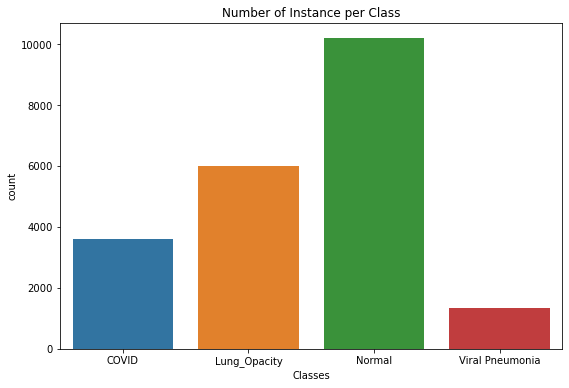

In [4]:
print("Class to Index correspondence")
display(flat_xrays.class_to_idx)
classes, class_counts = np.unique(flat_xrays.targets, return_counts=True)
flat_targets = flat_xrays.targets.copy()

print("\n{:15s}: Counts   ratio % of whole Dataset".format("Classes"))
for i in range(len(flat_xrays.classes)):
    print("{:15s}: {:6d}   {:5.2f} %"
          .format(flat_xrays.classes[i], class_counts[i], 
                  class_counts[i] / np.sum(class_counts) * 100))
print("{:15s}: {:6d}\n".format("Total", np.sum(class_counts)))

fig, ax = plt.subplots(1, figsize=(9, 6))

ax.set_title("Number of Instance per Class")
ax.set_xlabel("Classes")

targets_with_class_name = [flat_xrays.classes[x] for x in flat_targets]
sns.countplot(targets_with_class_name, ax=ax)

plt.show()

### 6. Visualzing one Chest X-ray Sample from the Dataset
To understand the Chest X-ray (CXR) image data, we will sample out one CXR image from the Dataset. We will check the image's **minimum and maximum** value (range of pixel values), the **distribution** of pixels value, and its **memory usage**. 

After transformation, each image contains **256 x 256 (65536) pixels** value of type `float32`, which is about **256 Kilobytes** (KB) in memory. The memory usage will explode if the whole image dataset (21165 images) is loaded into the memory (about 5 Gigabytes). The `ImageFolder` only store the **paths to the images** and corresponding class label in memory. `ImageFolder` loads images into memory only when users try to access the ImageFolder (e.g. `flat_xrays[0]`). 

C:\Anaconda3\envs\CSCI349\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


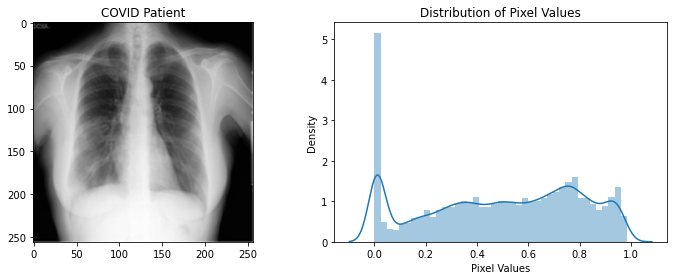

Minimum Pixel Values: 0.000
Maximum Pixel Values: 0.984
Mean Pixel Values: 0.497
Memory Usage: 256.000 KB


In [5]:
np.random.seed(0)
rand_idx = np.random.randint(len(flat_xrays))

sampled_image, target_idx = flat_xrays[rand_idx]
reshaped_image = sampled_image.reshape(ori_image_shape)
class_name = flat_xrays.classes[target_idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title("{:s} Patient".format(class_name))
ax[0].imshow(reshaped_image, cmap='gray')

ax[1].set_title("Distribution of Pixel Values")
sns.distplot(sampled_image, ax=ax[1])
ax[1].set_xlabel("Pixel Values")

plt.tight_layout()
plt.show()

print("Minimum Pixel Values: {:.3f}".format(sampled_image.min()))
print("Maximum Pixel Values: {:.3f}".format(sampled_image.max()))
print("Mean Pixel Values: {:.3f}".format(sampled_image.mean()))
print("Memory Usage: {:.3f} KB".format(sampled_image.nbytes / 1024))

### 7. Sample out 100 Chest X-rays from each Class: 400 Samples in total
As we see in the result of the previous cell, the memory usage of one single monochromatic image is **256 KB** already. The whole dataset, **21165 images**, will be about **5.17 GB** in total. It will be inefficient and impossible (for typical machines) to load such a large dataset into the memory. Therefore, in the subsequent data exploration analysis, we will focus on a **smaller subset** of Radiography datasets.

We will randomly sample **100 images from each class** to build the subset. The resulting sampled dataset will have **400 samples**/observations.

The reason that the Radiography dataset only occupies about 780 Megabytes (MB) on disk is the usage of **PNG compression**. PNG compression is a **lossless compression** that only encodes the predicted errors (**neighboring differences**) of an image [1]. Taking advantage of the **spatial coherence** in images, PNG compression can faithfully reconstruct the original image using only the encoded errors.

We will explore the **Spatial coherence** in the later section as it reveals a way to reduce the image data's dimensionality.

References:  
[1] Roelofs, G., "PNG: The Definitive Guide: Chapter 9. Compression and Filtering", [https://www.oreilly.com/library/view/png-the-definitive/9781565925427/18_chapter-09.html](https://www.oreilly.com/library/view/png-the-definitive/9781565925427/18_chapter-09.html)

In [6]:
num_sample_per_class = 100

sampled_xrays = []
for class_id in range(len(flat_xrays.classes)):
    sampled_xrays.append([np.stack([flat_xrays[i, class_id][0] 
                                    for i in np.random.choice(class_counts[class_id], num_sample_per_class)])])
sampled_xrays = np.array(sampled_xrays)
sampled_xrays = np.squeeze(sampled_xrays, axis=1)

print("The shape of the loaded flatten Chest-X Ray images is: ", sampled_xrays.shape)
print("The Memory usage of 400 samples is {:.3f} MB".format(sampled_xrays.nbytes / (1024 ** 2)))

The shape of the loaded flatten Chest-X Ray images is:  (4, 100, 65536)
The Memory usage of 400 samples is 100.000 MB


### 8. Normalize the intensity range of sampled Chest X-rays using Minmax
To standardize the image data, we apply the **Minmax normalization** on each CXR image. After the normalization, the range of each sampled CXR image will be [0, 1]. The **normalization** of image data **depends on the algorithms** which we will use and **the nature of this dataset** (e.g. if these Chest X-rays produced are by the same machine/standard, we can normalize them using the known mean and std of images produced from that machine/standard).

In [7]:
sampled_xrays[..., :] -= sampled_xrays[..., :].min()
sampled_xrays[..., :] /= sampled_xrays[..., :].max()

print("Maximum: ", sampled_xrays.max())
print("Minimum: ", sampled_xrays.min())

Maximum:  1.0
Minimum:  0.0


### 9. The First Challenge of Digital Image Data:
Before we start to explore the statistics of Chest X-Ray (CXR) images, let's acknowledge the **first challenge** we have discovered when working with Digital image data.

**Challenge**: The relatively **large size** of the digital image dataset will **inhibit the performance** of machine learning algorithms that have **high space complexity**. For our Radiography dataset, size ~5GB, it is impractical to load the whole dataset and train the machine learning model on it. We need machine learning models that **can be trained incrementally** using a smaller subset of Dataset (mini-batch).

Examples of incremental learning algorithms supported by `sklearn` can be found here: [https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning).

### 10. Mean, Median, and STD of the CXR Images
We will compute the **mean, median, and std** of the sampled images in each class. If we treat **each pixel as a variable** for the sample image, there will be 256 x 256 == **65536 variables** in this dataset. Using conventional methods such as histogram or distribution plot, we **cannot easily visualize the distributions** of such high dimensional datasets.

Moreover, the **values of pixels are meaningful** when we view them in the **context of an image**. A single pixel conveys little information, while a group of spatially adjacent pixels will allow us to visualize the meaningful local features of an image.

Thus, we will reconstruct the **mean, median, and std** of all pixels into the **image's original shape** using `np.reshape(flat_image, shape=ori_image_shape)`. We will also plot 3 randomly chosen patients from each class for comparisons.

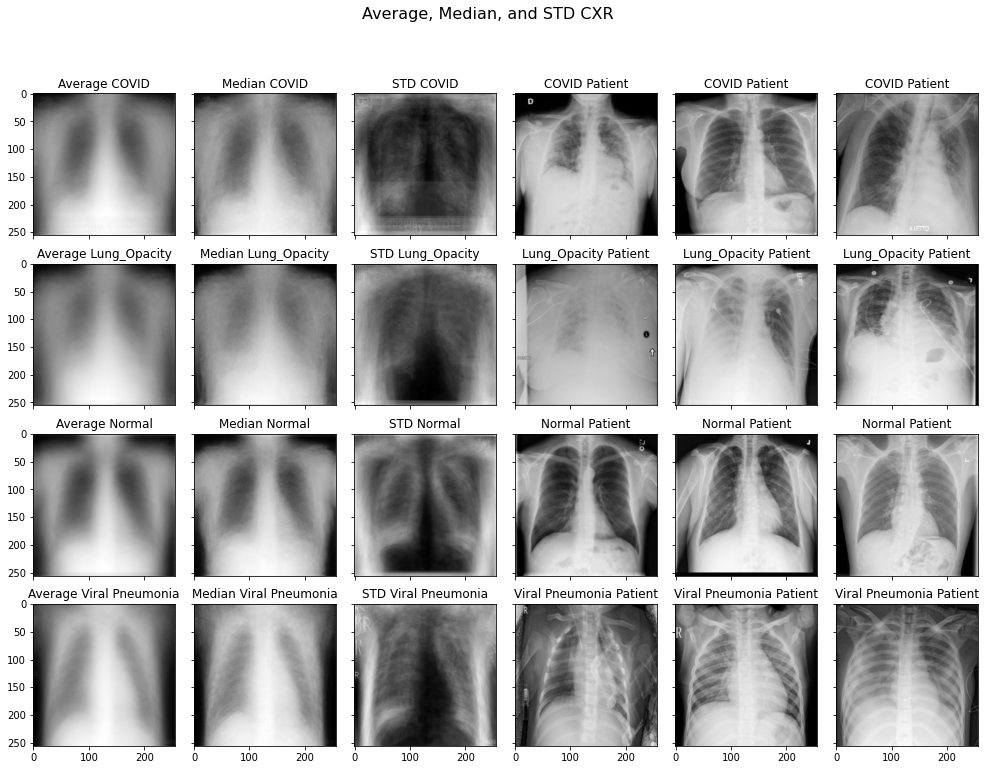

In [8]:
fig, ax = plt.subplots(4,6, figsize=(17, 12), sharey=True, sharex=True)

for class_id in range(len(flat_xrays.classes)):
    target_class = flat_xrays.classes[class_id]
    
    ax[class_id][0].imshow(np.reshape(sampled_xrays[class_id].mean(axis=0), ori_image_shape), cmap='gray')
    ax[class_id][0].set_title('Average {:s}'.format(target_class))
    
    ax[class_id][1].imshow(np.reshape(np.median(sampled_xrays[class_id], axis=0), ori_image_shape), cmap='gray')
    ax[class_id][1].set_title('Median {:s}'.format(target_class))

    ax[class_id][2].imshow(np.reshape(sampled_xrays[class_id].std(axis=0), ori_image_shape), cmap='gray')
    ax[class_id][2].set_title('STD {:s}'.format(target_class))

    selected_pat_indexes = np.random.choice(len(sampled_xrays[class_id]), 3, replace=False)
    for index in range(3):
        patient_index = selected_pat_indexes[index]
        ax[class_id][index + 3].imshow(sampled_xrays[class_id][patient_index].reshape(ori_image_shape), cmap='gray')
        ax[class_id][index + 3].set_title('{:s} Patient'.format(target_class))
    
fig.suptitle("Average, Median, and STD CXR ", fontsize=16)
plt.subplots_adjust(wspace=0.1)
plt.show()

Comparing the Median and Average CXRs from different classes, we can find the typical symptoms of infected lungs. For example, the **airspace of the lung** is clear and transparent in the Average CXR of normal patients. 

Compared with the Average CXR of normal patients, the airspace in the Average CXR for **viral pneumonia** is **hazy and diffused**, which are **features of GGO** that we have discussed in section 2 above.

The Average CXRs of **lung opacity** and **COVID-19** show more **intense pulmonary opacification** (more opaque compared with viral pneumonia), which may be the result of displacement of gas (transparent) by fluid (non-transparent) or airway collapse.

The **standard deviations of CXRs** from different classes **highlight** the **areas with large variation** (in brighter intensity, while the areas with small variation are darker in the plots). As we see on the plots, the areas with **large variations** are usually **around the edges of different structures (lung, rib cage, etc.)**. The other areas have, however, fewer variations across the patients in the same class.

### 11. The Second Challenge of Digital Image Data:
In the cells above, we find the second challenge of digital image data when we try to learn the statistics of image data.

**Challenge**: If we **treat each pixel value as a variable** for the image data, the digital image will have **huge dimensionality** that may inhibit us from learning data's statistics and fail the most of machine learning algorithms.

However, as we observe the **standard deviation of CXRs**, the pixel values do not experience high variation in every area, instead only the areas around the **edges of structures have relatively high variation**. Moreover, the pixel values of spatially adjacent pixels are correlated. This correlation is known as the **spatial coherence of digital images**.

### 12. Spatial Coherence: Neighboring Pixel Values are Correlated
Spatial coherence states that the values among the spatially neighboring pixels have a small or no difference. The **values of spatially adjacent pixels have a strong correlation**. In this cell, we will plot the **first-order gradient**, the difference between neighboring pixels, of a patient's CXR to visualize the spatial coherence. 

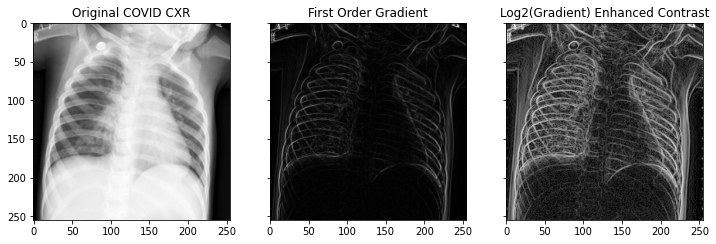

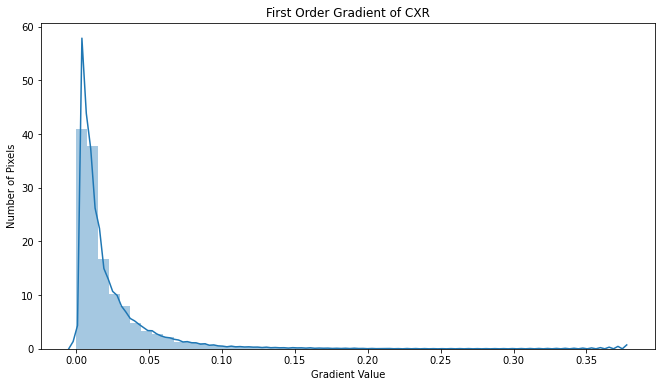

The mean of the Gradient is 0.021
The median of the Gradient is 0.012
The std of the Gradient is 0.027


In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

selected_cxr = sampled_xrays[3][70]
selected_cxr_image = selected_cxr.reshape(ori_image_shape)

dx = np.diff(selected_cxr_image, axis=0, n=1)[:, :-1]
dy = np.diff(selected_cxr_image, axis=1, n=1)[:-1, :]

gradient_image = np.sqrt(dx ** 2 + dy ** 2)

ax[0].set_title("Original COVID CXR")
ax[0].imshow(selected_cxr_image, cmap='gray')

ax[1].set_title("First Order Gradient")
ax[1].imshow(gradient_image, cmap='gray')

ax[2].set_title("Log2(Gradient) Enhanced Contrast")
# Apply the Intensity Transformation to Gradient Image
# To better view the gradient map
# See intensity transformation here: https://www.cs.uregina.ca/Links/class-info/425/Lab3/
ax[2].imshow(np.log2(gradient_image + 1e-2), cmap='gray')

plt.show()

fig, ax = plt.subplots(1, figsize = (11, 6))

ax.set_ylabel("Number of Pixels")
ax.set_xlabel("Gradient Value")

ax.set_title("First Order Gradient of CXR")
sns.distplot(gradient_image.ravel(), ax=ax)
plt.show()

print("The mean of the Gradient is {:.3f}".format(gradient_image.mean()))
print("The median of the Gradient is {:.3f}".format(np.median(gradient_image)))
print("The std of the Gradient is {:.3f}".format(gradient_image.std()))

As the histogram of the first-order gradient shows, for an image with intensity range [0, 1], the **difference** between the spatially adjacent pixels **is minimal** (**mean** gradient is **0.021** with **std 0.027**). This is also supported by the plot of gradient images, where the **majority of areas have minimal gradients** (dark area). The areas with a high gradient (brighter area) are usually the edge of objects.

Thus, we find it is **not optimal** to treat each pixel **as an individual variable** since the pixels have **a strong correlation** with their spatial neighbors. In fact, treating pixels as individual variables can be **detrimental** to the machine learning algorithms, such as the Naive Bayes classifier, that assume the **independence between variables**.

---
Note: On the third plot, **Log2(Gradient) Enhanced Contrast**, I apply an **intensity transformation** to enhance the **contrast** of the image so we can better visualize the image's content. Additional information about intensity transformation can be found here: [https://www.cs.uregina.ca/Links/class-info/425/Lab3/](https://www.cs.uregina.ca/Links/class-info/425/Lab3/).

---

### 13. Dimensionality Reduction: Apply Principal Component Analysis (PCA) to CXR Images
Treating **pixel values as variables** for an image sample, we will have **65536 variables** in total for a sample. 

The **high dimensionality** of image data will inhibit the performance of most machine learning methods, and the **strong correlation between spatially adjacent pixels** will violate the independence assumptions made by some machine learning algorithms. 

To **reduce the dimensionality**, we need a more efficient way to represent the image data. One option is to view each **image sample as a collection of patterns (images)**, which can be found by applying **Principal Component Analysis** (PCA). 

### 14. Create a PCA with 100 Components for our 400 Sampled Patients
In the subsequent cells, we will explore the **optimal number of components** for representing the images in this subset (400 patients). To perform the **PCA** on image data, we need to **flatten the image data**, which we have done in **section 4**. We will apply the **PCA** to the **whole subset** (all classes). Thus, we will reshape our `sampled_xrays` from (4, 100, 65536) to (400, 65536). 

In [10]:
sampled_all_xrays = sampled_xrays.reshape(sampled_xrays.shape[0] * sampled_xrays.shape[1], -1)
sampled_all_targets = (np.ones(shape=(4, 100), dtype=int) * np.arange(4).reshape(4, 1)).reshape(-1).tolist()

pca = PCA(n_components=100)
pca.fit(sampled_all_xrays)

PCA(n_components=100)

### 15. Plot the first 8 Principal Components as Images
Notice that I am using the **1-based index** when numbering the principal components. The `pca.components_` is **sorted** from the **high** explained variance to **low** explained variance.

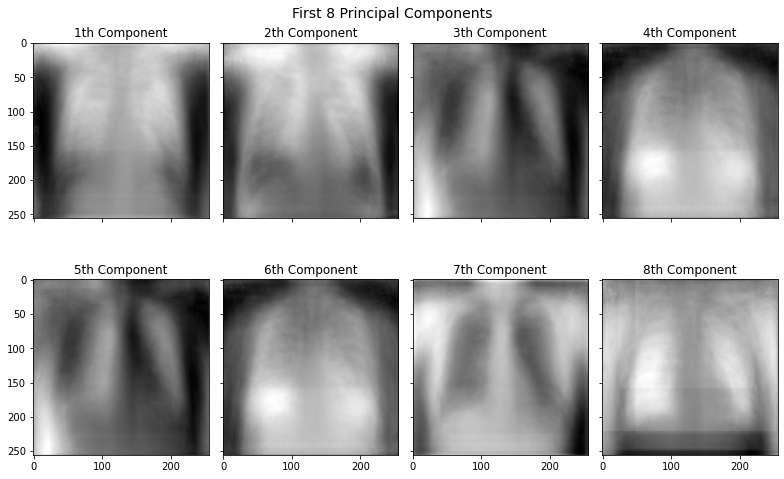

nth Components: Cumulative Variance Ratio
1th Components:             0.270
2th Components:             0.415
3th Components:             0.489
4th Components:             0.556
5th Components:             0.611
6th Components:             0.646
7th Components:             0.676
8th Components:             0.699


In [11]:
fig, ax = plt.subplots(2, 4, figsize=(11, 7), sharex=True, sharey=True)
for row in range(len(ax)):
    for col in range(len(ax[row])):
        ax[row][col].set_title("{:d}th Component".format(row * 4 + col + 1))
        ax[row][col].imshow(pca.components_[row * 2 + col].reshape(ori_image_shape), cmap='gray')
fig.suptitle("First 8 Principal Components", fontsize=14)

plt.tight_layout()
plt.show()

var_ratio = np.cumsum(pca.explained_variance_ratio_)[:8]
print("nth Components: Cumulative Variance Ratio")
for i in range(len(var_ratio)):
    print("{:d}th Components: {:17.3f}".format(i + 1, var_ratio[i]))

We capture **55%** of the variance at the **4th principal component**, and the **first 8** principal components capture about **70% of the variance**.

### 16. Plot the Cumulative Sum of the Variance Ratio at nth Components
To visualize the amount of variance captured at nth component, I plot the **cumulative sum of the variance ratio** at every component. The `pca.explained_variance_ratio_` is sorted from high variance ratio to low variance ratio, and the `pca.components_` is sorted from the high explained variance to low explained variance as well.

The **blue-dotted line** is the plot of **cumulative variance ratio** at nth components.  
The **red vertical line** marks the point where the principal components captured **> 90%** of the variance.  
The **orange line** shows the **explained variance ratio of nth components** (the change in cumulative variance ratio).

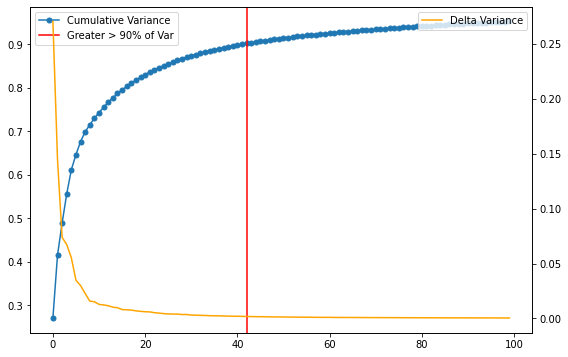

> 90% of Variance:
At 43 th Component, the principal components captured 90.14% of variance


In [12]:
fig, ax = plt.subplots(1, figsize=(9, 6))
cum_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
ninety_var = np.argmax(cum_variance_ratio > 0.9)

ax.plot(cum_variance_ratio, marker='o', markersize=5, label="Cumulative Variance")
ax.axvline(ninety_var, 0, 1, c='r', label="Greater > 90% of Var")
plt.legend()

ax2 = ax.twinx()
ax2.plot(pca.explained_variance_ratio_, color="orange", label="Delta Variance")

plt.legend()
plt.show()

print("> 90% of Variance:")
print("At {:d} th Component, the principal components captured {:.2f}% of variance"
      .format(ninety_var + 1, cum_variance_ratio[ninety_var] * 100))

### 17. Visualize How Images are Separate on the Axis of First 2 Principal Components

First, we sampled out **12 CXRs** from the subset, and transform them using the PCA, `coeff = pca.fit_transform(sampled_all_xrays)`. The first 2 coefficients of principal components, `coeff[plot_cxr, :2]`, will be used as the (x, y) coordinates for the images in the plot below.

#### Sampling 12 CXRs

In [13]:
np.random.seed(30) 
coeff = pca.fit_transform(sampled_all_xrays)
plot_cxr = np.random.choice(len(sampled_all_xrays), 12, replace=False)
xy_pos = coeff[plot_cxr, :2]

#### Plot the samples on the axis of **the first 2 principal components**.

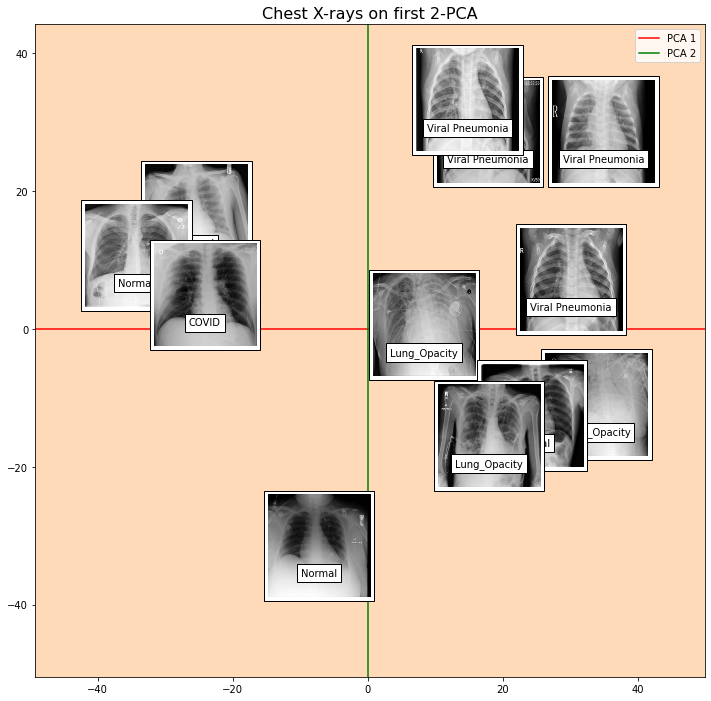

In [14]:
fig, ax2 = plt.subplots(figsize=(12,12))
ax2.set_title('Chest X-rays on first 2-PCA', fontsize=16)
ax2.set_facecolor("peachpuff")

for i, xy in zip(plot_cxr, xy_pos):
    arr_img = np.reshape(sampled_all_xrays[i, :], ori_image_shape)
    target_class_index = sampled_all_targets[i]
    
    # See: https://matplotlib.org/examples/pylab_examples/demo_annotation_box.html
    # For the usage of offset and annotation box
    imagebox = OffsetImage(arr_img, zoom=0.4, cmap='gray')
    imagebox.image.axes = ax2
    
    # xy is 4-d here, just need the first 2 to plot though.
    ab = AnnotationBbox(imagebox, xy + [0, 4])
    
    ax2.add_artist(ab)
    
    textbox = TextArea(flat_xrays.classes[target_class_index])

    ab = AnnotationBbox(textbox, xy)
    
    ax2.add_artist(ab)
    
ax2.axhline(0, 0, 1, label="PCA 1", c="r")
ax2.axvline(0, 0, 1, label="PCA 2", c="g")
    

ax2.set_xlim(xy_pos[:,0].min() - 15, xy_pos[:,0].max() + 15)
ax2.set_ylim(xy_pos[:,1].min() - 15, xy_pos[:,1].max() + 15)

plt.legend()
plt.show()

From the plot above, we can see how well does the CXRs from different classes separate on the first 2 principal components. Remember that **the first 2 principal components** only capture **41.5%** of the variance. If you rerun the sampling and plot cells above several times, you will observe that some CXRs are **not well separate** from the images of different classes. 

Their closeness to the first 2 principal components indicates they have some **similar underlying patterns**. To further separate them, we can introduce **more principal components** into the analysis. 

Yet, the question is: What is the **optimal number of principal components**?

### 18. Optimal Number of Components: Reconstructed a CXR using Principal Components and Coefficients
Another way to visualize the effect of dimensionality reduction by PCA is to compare the difference between the original data and the data reconstructed using principal components. The **difference** between the original data and its projection on the low-dimensional space (space of principal components) is also known as **reconstruction error** (see [slide 10](http://www.cs.cmu.edu/~02317/slides/lec_6.pdf) of this lecture from Carnegie Mellon University). 

We can reconstruct a variable using its **PCA coefficients/scores** with the formula [1] below:

$$ \text{Reconstructed Variable} = \text{PCA Coefficients} \cdot \text{Principal Components} + \mu \text{(Principal Components)}$$ 

Where $\cdot$ means a dot product, and $\text{PCA Coefficients}$, $\text{Principal Components}$, and $\mu$ are vectors.

The **MAE** in the plot below stands for the **Mean absolute error** of pixel values.

Reference:  
[1] amoeba, How to reverse PCA and reconstruct original variables from several principal components?, [https://stats.stackexchange.com/a/229093](https://stats.stackexchange.com/a/229093)

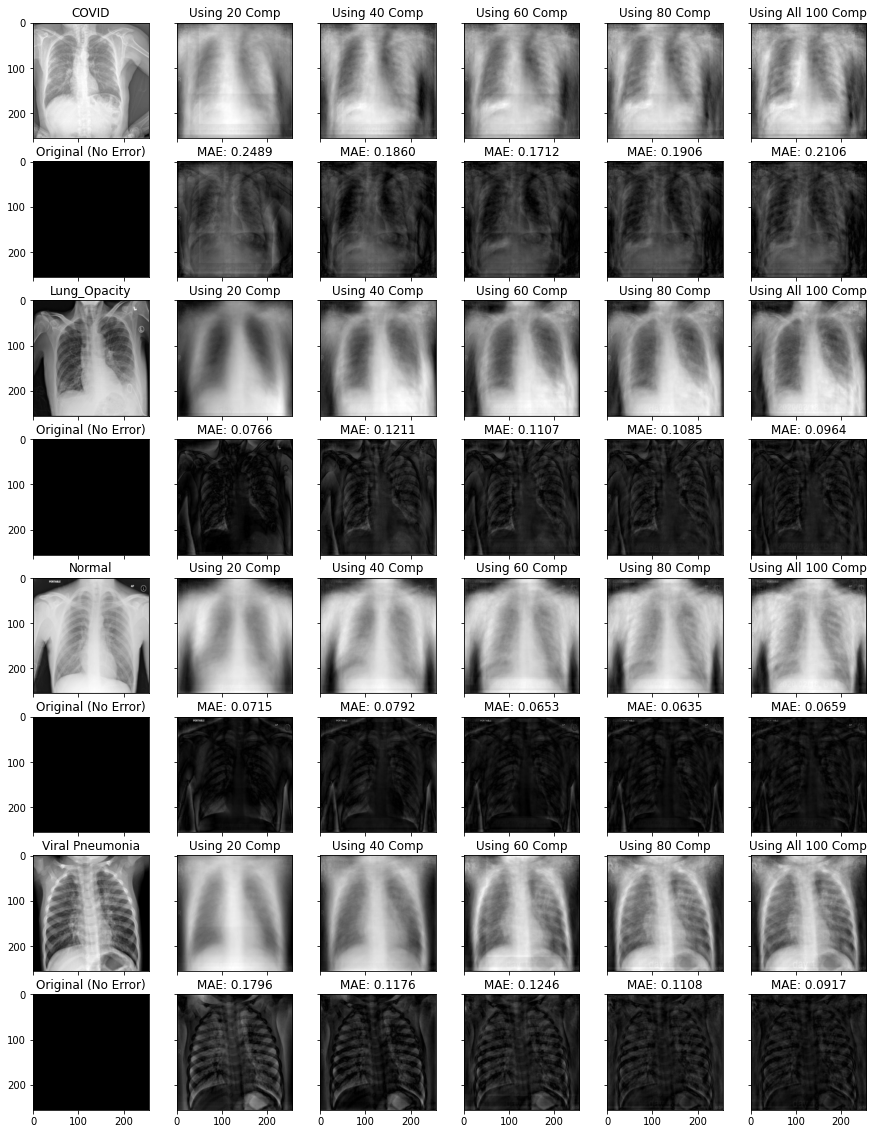

In [15]:
num_patients = 4

pcas = np.concatenate([pca.mean_.reshape(1, -1), pca.components_])

selected_cxrs_indexes = np.random.choice(len(sampled_xrays[0]), num_patients, replace=False)

fig, ax = plt.subplots(num_patients * 2, 6, figsize=(15, 20), sharey=True, sharex=True)

for nth_cxr in range(len(selected_cxrs_indexes)):
    selected_index = selected_cxrs_indexes[nth_cxr]
    selected_cxr = sampled_xrays[nth_cxr][selected_index]
    
    pca_coeff = np.squeeze(pca.transform(selected_cxr.reshape(1, -1)))
    pca_coeff = np.concatenate([[1], pca_coeff])

    ori_cxr = selected_cxr.reshape(ori_image_shape)

    recon_images = [ori_cxr]

    ax[2 * nth_cxr][0].imshow(ori_cxr, cmap='gray')
    ax[2 * nth_cxr][0].set_title("{:s}".format(flat_xrays.classes[nth_cxr]))

    step = 20
    for index, nth_comp in zip(range(6), range(19, pca.n_components + 1, step)):
        image = np.dot(pca_coeff[:nth_comp], pcas[:nth_comp]).reshape(ori_image_shape)
        image -= image.min()
        image /= image.max()
        if (nth_comp + 1) == pca.n_components:
            ax[2 * nth_cxr][index + 1].set_title("Using All {:d} Comp".format(nth_comp+1))
        else:
            ax[2 * nth_cxr][index + 1].set_title("Using {:d} Comp".format(nth_comp+1))
        ax[2 * nth_cxr][index + 1].imshow(image, cmap='gray')
        recon_images.append(image)

    for index in range(len(recon_images)):
        error = abs(ori_cxr - recon_images[index])
        if index == 0:
            ax[2 * nth_cxr + 1][0].set_title("Original (No Error)")
        else:
            ax[2 * nth_cxr + 1][index].set_title("MAE: {:.4f}".format(error.mean()))
        ax[2 * nth_cxr + 1][index].imshow(error, cmap="gray", vmin=0, vmax=1)

plt.show()

As the plot shows, the **Mean Absolute Error (MAE)** decreases as we introduce more principal components into the reconstruction. The details of the reconstructed images become visible when we keep more principal components.

In **section 16**, we found that **90% of the variance** is captured when we use the **first 43 principal components**, which is a good reduction in the image data's dimensionality (65536 originally). The number of 43 variables will allow us to apply many machine learning algorithms to the image data.

**However, three issues are remaining:**  
1. We perform the PCA on a **small subset** (400 patients) of the original datasets (22165 patients). The **number of principal components needed** for the analysis of the whole dataset can be **much larger**.  
2. It is **impossible to fit** the whole image dataset (21165 images ~5GB) with PCA **all at once**. We need to **perform the PCA incrementally** using a mini-batch of image data. Thankfully, sklearn provides a way to do this: [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)
3. Finally, it is **harder to interpret the model** using the PCA transformed variables. As we see in section 15 above, the global patterns of images found by PCA are not intuitive.

Using PCA, we transform the image data into **a linear combination of the global patterns** (principal components) of the dataset. However, when we watch an image, we not only focus on the global patterns. Additionally, we decompose an image into **a collection of specific local features** (e.g. the crying eyes or a smiling mouth) and investigate them. Similarly, when clinicians analyze medical images, they are looking for certain symptoms like GGO. **Certain kinds of local features**, such as the hazy lung in the Chest X-Rays, **will be more important** for the analysis than the general patterns among the images.

A more efficient way of analyzing the image data is, however, to analyze the **spatially adjacent pixels in groups**. We need a model that can capture the image's **spatial features** and **hierarchically** analyze them (e.g. from low-level details, such as object's edges or boundaries, to high-level abstract information, such as eyes or nose).

One way to extract **spatial features** from imagery data is to use **spatial filters**.

### 19. Spatial Filter: Local Features of a Digital Image
To extract **local features** from an image, we can use **filters** (special matrices) to **convolute** across the images. The spatial filter will convolve across the image. The sum of products between the elements in the filter and elements in the subwindow of the image will be assigned to the outputs.

<figure class="image">
    <img src="https://miro.medium.com/max/654/1*hy15RJHCqT4HzO2VUydjTw.png" width="400" height="" />
    <figcaption>Fig 1. Convolution between an image and a filter matrix. [1]</figcaption>
</figure>

The outputs from a spatial filter indicate the **existence of a certain spatial feature**. For example, the sobel X and sobel Y filters can detect the change of values in the X-direction and Y-direction. In the cell below, I will show how to use the **sobel x** and **sobel y** filters to extract the **vertical** (changes in the x-direction) and **horizontal edges** (changes in the y-direction) from a CXR image.

<figure class="image">
    <img src="https://www.projectrhea.org/rhea/images/thumb/9/91/XY_Kernels.png/750px-XY_Kernels.png" width="400" height="" />
    <figcaption>Fig 2. Sobel X and Sobel Y filters (matrices) [2]</figcaption>
</figure>

References:  
[1] Prakash, A., "Machine Learning - Convolution for image processing", [https://blog.francium.tech/machine-learning-convolution-for-image-processing-42623c8dbec0](https://blog.francium.tech/machine-learning-convolution-for-image-processing-42623c8dbec0)  
[2] Sodha, S., "An Implementation of Sobel Edge Detection", [https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection](https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection)

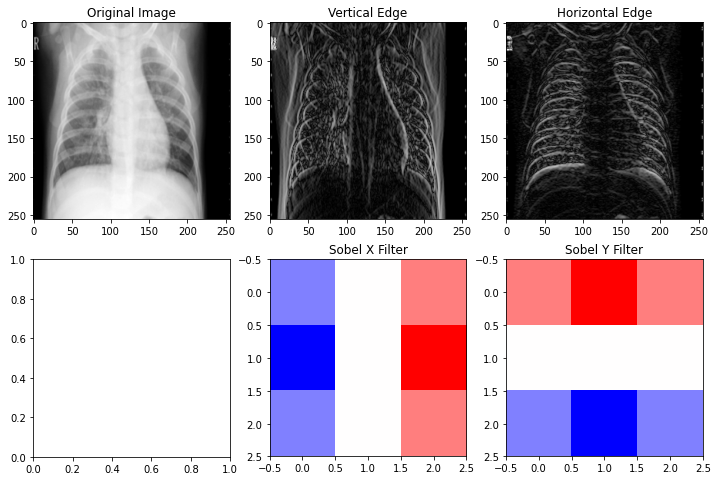

In [16]:
from scipy import ndimage

selected_cxr = sampled_xrays[3][10].reshape(ori_image_shape)
sobel_hor = abs(ndimage.sobel(selected_cxr, axis=0))
sobel_hor_filter = [[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]]

sobel_ver = abs(ndimage.sobel(selected_cxr, axis=1))
sobel_ver_filter = [[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]]

fig, ax = plt.subplots(2, 3, figsize=(12, 8), )

ax[0][0].set_title("Original Image")
ax[0][0].imshow(selected_cxr, cmap='gray')

# Again, I apply an intensity transformation on the sobel filtered image
# Thus, we can better visualize the image's content with enhanced contrast
ax[0][1].set_title("Vertical Edge")
ax[0][1].imshow(np.log(sobel_ver + 1e-1), cmap='gray')

ax[0][2].set_title("Horizontal Edge")
ax[0][2].imshow(np.log(sobel_hor + 1e-1), cmap='gray')

ax[1][1].set_title("Sobel X Filter")
ax[1][1].imshow(sobel_ver_filter, cmap='bwr')

ax[1][2].set_title("Sobel Y Filter")
ax[1][2].imshow(sobel_hor_filter, cmap='bwr')

plt.show()

The filters that we used above are the fixed/pre-defined filters that extract **a specific kind of feature** from an image (e.g. horizontal lines). However, CXR images certainly have more significant local features which **cannot be extracted by a known/pre-defined filters**. We need a **learnable filter** that can be trained to bias the significant features (e.g. symptoms of viral pneumonia). 

To achieve this, one possible solution is to use the **Convolutional Neural Network (CNN)**.

## Introduction to the Method: Convolutional Neural Network (CNN)

#### What is a convolutional neural network?
A Convolutional neural network (CNN) is a **regularized deep neural network**. Similarly to the fully connected neural networks, they use the **feed-forward** and **gradient descent** in tuning its model's weights. However, as a regularized deep neural network, CNN can be applied to the **data with high-dimensionality** using the **partially connected layers** (e.g. layers of spatial filters) and **convolutions** (math operations). Thus, CNN can be applied to **problems with high-dimensional spaces**, such as **image classification**, segmentation, audio, and video recognition.

#### How is CNN regularized?
The convolutional neural network takes advantage of the **spatial coherence** (see section 12) presented in the data to reduce the network's redundant parameters with **partially connected layers** and **convolution**.

For illustration, assume we have an input image with the shape $32 \times 32$ (height x width = $1024$ pixels). If we decide to feed it into a hidden layer of $16 \times 16$ neurons ($256$ neurons) in a fully connected neural network. Then, each neuron will connect to every pixel in the input image. A neuron will have $32 \times 32$ weights (in-connections) $+ 1$ bias. The hidden layer will then have $(32 \times 32 + 1) \times 16 \times 16 = 262,400$ weights and bias in total.

However, as we discussed in section 12, the values of **spatially adjacent** pixels are **strongly correlated**. The fully connected layer will hence create many **redundant** connections. To prune the redundant parameters, we want **every neuron** to connect with **only one** spatially adjacent **group of pixels** (e.g. a **3 x 3** region). 

Therefore, by taking advantage of the data's spatial coherence, we reduce the number of weights from $(32 \times 32 + 1) \times 16 \times 16 = 262,400$ to $(3 \times 3 + 1) \times 16 \times 16 = 2560$ (**~1%** of the original).

<figure class="image">
    <img src="https://www.researchgate.net/profile/Eftim-Zdravevski/publication/327765620/figure/fig3/AS:672852214812688@1537431877977/Fully-connected-neural-network-vs-convolutional-neural-network-with-filter-size-1-2_W640.jpg" width="200" height="" />
    <figcaption>Fig 1. Fully connected layer (above) vs. Partially and locally connected layer (below). [1]</figcaption>
</figure>

Furthermore, as we discussed at the end of section 18, **some features** in the images are **more important** for the analysis than the other general patterns. Therefore, instead of having $16 x 16$ different neurons, we reduce them to only **one neuron** with weights $=3 x 3$. The neuron will act as a **learnable spatial filter** (see section 19) that convolutes across the image. The output will hence be **a map of a specific spatial feature** on which the neuron/filter biases. 

<figure class="image">
    <img src="https://mlnotebook.github.io/img/CNN/convSobel.gif" width="400" height="" />
    <figcaption>Fig 2. Filter convolutes across the input image and produces a feature map [3]. Notice that the filter is a Sobel-y filter which detects change in y-direction.</figcaption>
</figure>

However, analysis may certainly **need more than one type of features** from the input image. To increase the number of features learned by the filter, we **increase the depth of filter**. You can also think this as **appending more matrices** (spatial filter with depth 1) to the filter. Each depth of filter will convolute across the image and produce a map of feature. If we decided to extract **16 different features** from an input $32 x 32$ image, we will end up having $(3 \times 3 + 1) \times 16 = 160$ weights and bias (**only 0.06%** of the original).

If the image or input feature maps from previous layer **contains more than one channel of information** (e.g. RGB color image), the filter will **replace the numeric value** inside each cell of matrices to **a vector** whose length is the number of channels/depth of the input.

Thus, the general formular for the number of weights and bais inside a convolutional layer is:
$$[(\text{ Height}_{filter} \times \text{Width}_{filter} \times \text{Depth}_{input} + 1)] \times \text{Depth}_{output} $$

By introducing **additional convolutional layers**, CNN will be able to capture the **hierarchical features** (low-level details to high-level patterns) in the data. CNN can be further pruned using max pooling and dropout layers.

References:  
[1] Albawi, S. et al., "Understanding of a Convolutional Neural Network", [https://www.researchgate.net/publication/319253577_Understanding_of_a_Convolutional_Neural_Network](https://www.researchgate.net/publication/319253577_Understanding_of_a_Convolutional_Neural_Network)  
[2] Stojov, V. et al., "Application of machine learning and time-series analysis for air pollution prediction", [https://www.researchgate.net/publication/327765620_Application_of_machine_learning_and_time-series_analysis_for_air_pollution_prediction](https://www.researchgate.net/publication/327765620_Application_of_machine_learning_and_time-series_analysis_for_air_pollution_prediction)  
[3] Phillips, T., "Exercise Classification with Machine Learning (Part II)", [https://towardsdatascience.com/exercise-classification-with-machine-learning-part-ii-d60d1928f31d](https://towardsdatascience.com/exercise-classification-with-machine-learning-part-ii-d60d1928f31d)

---

## Data Preparation

### 20. Make the CXR Dataset Using ImageFolder with Transformations
For the Radiography Classification problem, we will use the features extractor of **pretrained CNN models**, which are tuned on the [ImageNet](https://www.image-net.org/) Dataset, a large visual recognition dataset that contains millions of images from thousands of categories. 

The **pretrained deep learning models** (e.g. [ResNet 50](https://pytorch.org/hub/pytorch_vision_resnet/)) expects the input images to:  
* be a 3-channel RGB images
* with width >= 224 pixels and height >= 224 pixels
* be first loaded into a range of `[0, 1]`
* then normalized with mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]` (3-channel (R, G, B)).

Therefore, in the `ImageFolder` dataset below, we will apply the transformations: 
1. transforms.Resize((256, 256)): **Resize** the image into size (height=256, width=256).
2. transforms.ToTensor(): Convert the PIL image to a torch.Tensor Object
3. MinMaxNorm(): **Normalize** the Tensor Image **to range of `[0, 1]`** using Min-Max normalization
4. transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)): **Normalize** the image with mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]`

Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ../data/COVID-19_Radiography_Dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear)
               ToTensor()
               MinMaxNorm(): Normalize the tensor image to range [0, 1]
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

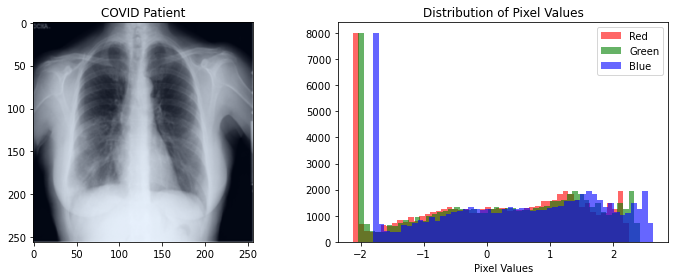

In [11]:
class MinMaxNorm(object):
    """
    MinMax Normalization
    Normalize the image to a range of [0, 1]
    """
    def __call__(self, tensor_image):
        """
        :param tensor_image: The tensor image that will be normalized
        :type tensor_image: torch.Tensor
        :return: a MinMax normalized tensor image
        :rtype: torch.Tensor
        """
        tensor_image -= tensor_image.min()
        tensor_image /= tensor_image.max()
        
        return tensor_image
    
    def __repr__(self):
        return self.__class__.__name__+'(): Normalize the tensor image to range [0, 1]'

    
# Load the Whole dataset
data_xrays = ImageFolder('../data/COVID-19_Radiography_Dataset/', 
                       transform=transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           MinMaxNorm(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                       ]))

display(data_xrays)

# Mannually set up the seed for numpy module (Reproducibility)
np.random.seed(0)
rand_idx = np.random.randint(len(data_xrays))

# Randomly Sampled out an Image for visualization
sampled_image, target_idx = data_xrays[rand_idx]

# To plot the image we need transform the image's shape from
# [Channel x Height x Width] to [Height x Width x Channel]
sampled_image = sampled_image.numpy().transpose([1, 2, 0])
# And MinMax normalize the image
plotable_image = sampled_image - sampled_image.min()
plotable_image /= plotable_image.max()

# Name of image's class
class_name = data_xrays.classes[target_idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title("{:s} Patient".format(class_name))
ax[0].imshow(plotable_image)

# Histogram of image's RGB values
ax[1].set_title("Distribution of Pixel Values")
ax[1].hist(sampled_image[..., 0].ravel(), label="Red", color='r', alpha=0.6, bins=50)
ax[1].hist(sampled_image[..., 1].ravel(), label="Green", color='g', alpha=0.6, bins=50)
ax[1].hist(sampled_image[..., 2].ravel(), label="Blue", color='b', alpha=0.6, bins=50)
ax[1].set_xlabel("Pixel Values")

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

## Model: CNN Architectures
In this project, I used two established CNN architectures for the Radiography Classification problem.

### 21. CNN Architecture 1: Residual Net 50-Layer
The first CNN Architecture that we will test on our dataset is **Residual Net with 50 layers**. The model, ResNet 50, has about **20 million parameters** which allow it to perform extremely well on the **image classification** problems. The ResNet achieves [1] a 3.57% error on the test set of the ImageNet dataset, and it won the ILSVRC 2015 classification task. 

<figure class="image">
    <img src="https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and_W640.jpg" width="650" height="" />
    <figcaption>Fig 1. Architecture of the ResNet 50-Layer [2]</figcaption>
</figure>

In this project, we will use the **feature extractor** of the ResNet 50 pretrained on the ImageNet dataset. The image features learned in the ImageNet dataset can **well represent the features in other images**. However, our classification problem is changed. Instead of recognizing objects in ImageNet, we want to classify the pneumonia infections from CXR images. Therefore, we will replace the output layer of ResNet's classifier with a new convolutional layer that has the correct number of outputs == 4, and **retrain the classifier** on our CXR dataset.

References:  
[1] He, K., et al., "Deep Residual Learning for Image Recognition", [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385)  
[2] Mahmood, A., et al., "Automatic Hierarchical Classification of Kelps Using Deep Residual Features", [https://www.researchgate.net/publication/338603223_Automatic_Hierarchical_Classification_of_Kelps_Using_Deep_Residual_Features](https://www.researchgate.net/publication/338603223_Automatic_Hierarchical_Classification_of_Kelps_Using_Deep_Residual_Features)

### 22. CNN Architecture 2: DenseNet 121-Layer
The second CNN architecture we proposed for this problem is DenseNet 121-Layer with about **7 million parameters**. According to the authors of this architecture, Huang et al. [1], DenseNet shows improvement on four benchmark datasets (CIFAR-10, CIFAR-100, SVHN, and ImageNet) over the previous state-of-art results, while **consuming less computational resources** (7 million parameters compared to the 20 million parameters of ResNet 50).

<figure class="image">
    <img src="https://miro.medium.com/max/875/1*B0urIaJjCIjFIz1MZOP5YQ.png" width="800" height="" />
    <figcaption>Fig 1. Architecture of the DenseNet 121-Layer [2]</figcaption>
</figure>

In this project, we will use the **feature extractor** of the DenseNet 121 pretrained on the ImageNet dataset. Again, the image features learned in the ImageNet dataset can **well represent the features in other images**. Yet, we need to replace the output layer of densenet's classifier with a new convolutional layer that has the correct number of outputs == 4, and **retrain the classifier** on our dataset.

References:  
[1] Huang, G., et al., "Densely Connected Convolutional Networks", [https://arxiv.org/abs/1608.06993](https://arxiv.org/abs/1608.06993)  
[2] Ruiz, P., "Understanding and visualizing DenseNets", [https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a)

### 23. Compare Performance of Models on a Smaller Subset (2500 Images) of Dataset (21165 Images) 

I used a **smaller subset, 2500 images**, of the whole dataset, 22165 images, for testing and tuning the deep learning models. To make the subset a good approximation of the whole dataset, we will **preserve the original ratios** between classes in the subset. To achieve this, we will specify the `stratify` argument to be the class labels of samples in the `train_test_split` function. 

In [12]:
class_names = data_xrays.classes

# If you have out of memory error, you may wish to scale down the batch_size
# Spec: This notebook is running on a RTX2080 Ti with 14 GB of graphic memory.
train_batch_size = 128
test_batch_size = 128

test_data_size = 500
train_data_size = int(test_data_size * 4)

np.random.seed(0)
torch.manual_seed(0)

train_indices, test_indices = model_selection.train_test_split(np.arange(len(data_xrays.samples)), 
                                                               random_state=0,
                                                               test_size=test_data_size, 
                                                               train_size=train_data_size,
                                                               stratify=data_xrays.targets)

trainData = torch.utils.data.Subset(data_xrays, train_indices.tolist())
testData = torch.utils.data.Subset(data_xrays, test_indices.tolist())

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(trainData,
    batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(testData,
    batch_size=test_batch_size, shuffle=True, **kwargs)

When we test and train the deep neural networks, using a smaller subset can **save lots of time** and allow us to **explore more sets of hyper-parameters**. At the same time, the results from the subset will still be a **good approximation** of network's performance **on the whole dataset** if we carefully choose the subset. In our case, we need to preserve the class ratio of this imbalanced dataset in its subset.

### 24. Check the Number of Instances per Class in Subset: Perserving Class Ratios
We want to make sure the **ratios between classes are preserved** in the smaller subset. 

In this cell, we will count the number of instances from each class and the ratios of each class in the whole dataset and subset. We will also plot the counts of class instances for the whole dataset and subset as a histogram.

Class to Index correspondence


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

Whole Dataset

Classes        : Counts   ratio % of whole Dataset
COVID          :   3616   17.08 %
Lung_Opacity   :   6012   28.41 %
Normal         :  10192   48.15 %
Viral Pneumonia:   1345    6.35 %
Total          :  21165

Subset Dataset

Classes        : Counts   ratio % of Subset
COVID          :    427   17.08 %
Lung_Opacity   :    710   28.40 %
Normal         :   1204   48.16 %
Viral Pneumonia:    159    6.36 %
Total          :   2500



C:\Anaconda3\envs\CSCI349\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\CSCI349\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


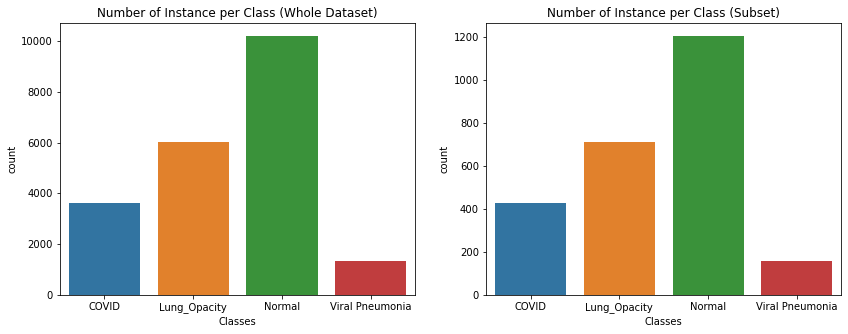

In [13]:
print("Class to Index correspondence")
display(data_xrays.class_to_idx)

# Class counts of the whole dataset
classes, class_counts = np.unique(data_xrays.targets, return_counts=True)
data_targets = data_xrays.targets.copy()

print("Whole Dataset")
print("\n{:15s}: Counts   ratio % of whole Dataset".format("Classes"))
for i in range(len(data_xrays.classes)):
    print("{:15s}: {:6d}   {:5.2f} %"
          .format(data_xrays.classes[i], class_counts[i], 
                  class_counts[i] / np.sum(class_counts) * 100))
print("{:15s}: {:6d}\n".format("Total", np.sum(class_counts)))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the count plot of class instances in the whole set
ax[0].set_title("Number of Instance per Class (Whole Dataset)")
ax[0].set_xlabel("Classes")

targets_with_class_name = [data_xrays.classes[x] for x in data_targets]
sns.countplot(targets_with_class_name, order=data_xrays.classes, ax=ax[0])

# Class counts of the subset
subset_targets = np.array(data_xrays.targets)[train_indices.tolist() + test_indices.tolist()]
subset_classes, subset_class_counts = np.unique(subset_targets, return_counts=True) 

print("Subset Dataset")
print("\n{:15s}: Counts   ratio % of Subset".format("Classes"))
for i in range(len(data_xrays.classes)):
    print("{:15s}: {:6d}   {:5.2f} %"
          .format(data_xrays.classes[i], subset_class_counts[i], 
                  subset_class_counts[i] / np.sum(subset_class_counts) * 100))
print("{:15s}: {:6d}\n".format("Total", np.sum(subset_class_counts)))

# Plot the count plot of class instances in the subset
targets_with_class_name_subset = [data_xrays.classes[x] for x in subset_targets]
sns.countplot(targets_with_class_name_subset, order=data_xrays.classes, ax=ax[1])

ax[1].set_title("Number of Instance per Class (Subset)")
ax[1].set_xlabel("Classes")

plt.show()

### 25. Compare the Performance of DenseNet-121 and ResNet-50 Using 5-Fold Cross Validation

#### 25.1 Statistics of 5-Fold Cross Validation with ResNet 50-Layer
The cell below visualizes ResNet 50's performance on the 2500 images using the 5-fold cross validation. I output the `classification_report` and plot the `confusion_matrix`.

The results are the **test results of epochs with the minimum loss** at each fold.

                 precision    recall  f1-score   support

          COVID       0.82      0.77      0.80       427
   Lung_Opacity       0.80      0.80      0.80       710
         Normal       0.85      0.87      0.86      1204
Viral Pneumonia       0.88      0.89      0.88       159

       accuracy                           0.83      2500
      macro avg       0.84      0.83      0.84      2500
   weighted avg       0.83      0.83      0.83      2500



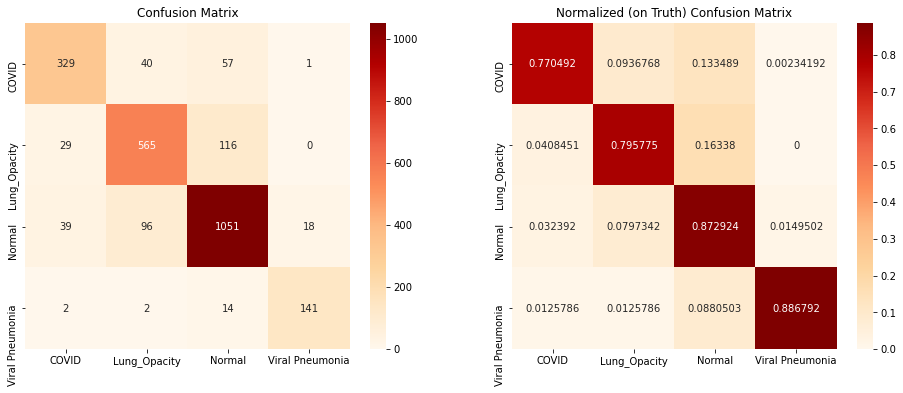

In [14]:
df_cross_results_resnet = pd.read_csv("subset_saved_5_fold_resnet50_results.csv")

truth = df_cross_results_resnet["True_Label"]
pred = df_cross_results_resnet["Predictions"]

print(classification_report(truth, pred, 
                            target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(truth, pred), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(truth, pred, normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

According to the classification report, ResNet 50 achieves a **macro f1** score of **0.84** and an **accuracy of 0.84** on the **2500** images. Based on the precision score, ResNet **performs the best on the Viral Pneumonia** classification with the support of 159 samples. ResNet performs **relatively worse on the COVID** (support of 427 images) and **Lung_Opacity** (support of 710 images) with the **precision of 0.82**. 

Notice in the **normalized confusion matrix**, **17.04%** of the Lung_Opacity patients are misclassified as normal patients. 

There are two possible reasons for this error: 

* (1) **similar spatial features** between normal and lung opacity patients. In contrast to viral pneumonia where the Lung area is globally hazy (a more distinguished symptom), lung opacity is sometimes a **local blockage** of airways that increase the **opacity of only certain local regions**. Thus, the lung opacity CXR images, in general, may still look like a normal patient's CXR. 
* (2) **Class imbalanced**: Too many normal patients' CXR (1204 images) in the dataset make model bias toward the optimization on a normal class.

---

#### 25.2 Statistics of 5-Fold Cross Validation with DenseNet 121-Layer
The cell below visualizes the DenseNet 121's performance on the 2500 images using the 5-fold cross validation. I output the `classification_report` and plot the `confusion_matrix`.

The results are the **test results of epochs with the minimum loss** at each fold.

                 precision    recall  f1-score   support

          COVID       0.86      0.72      0.78       427
   Lung_Opacity       0.79      0.82      0.80       710
         Normal       0.84      0.88      0.86      1204
Viral Pneumonia       0.91      0.82      0.86       159

       accuracy                           0.83      2500
      macro avg       0.85      0.81      0.83      2500
   weighted avg       0.83      0.83      0.83      2500



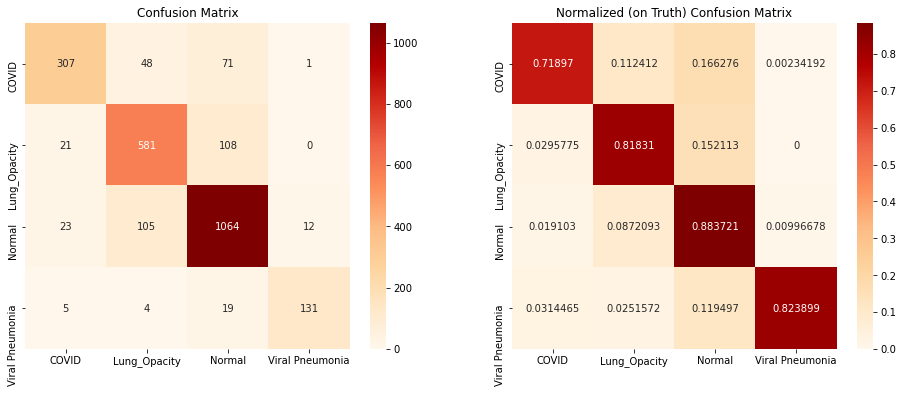

In [15]:
df_cross_results_densenet = pd.read_csv("subset_saved_5_fold_densenet121_results.csv")

truth = df_cross_results_densenet["True_Label"]
pred = df_cross_results_densenet["Predictions"]

print(classification_report(truth, pred, 
                            target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(truth, pred), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(truth, pred, normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

According to the classification report, DenseNet 121 achieves a **macro f1** score of **0.84** and an **accuracy of 0.83** on the **2500** images. Based on the precision score, DenseNet 121 **performs the best on the Viral Pneumonia** classification with a score of **0.92** and support of 159 samples. ResNet performs **relatively worse on the Lung_Opacity** (support of 710 images) with a **precision of 0.79**. 

Notice in the **normalized confusion matrix**, **16.62%** of the COVID patients and **14.78%** of the lung opacity patients are misclassified as normal patients. 

Again, there are two possible reasons for this error: 

* (1) **similar spatial features** among the CXR images of the COVID, Lung opacity, and normal patients. 
* (2) **Class imbalanced**: Too many normal patients' CXR (1204 images) in the dataset make model bias toward the **optimization on a normal class**.

---

Based on the **macro f1 score** and **overall accuracy**, the performance of ResNet-50 and DenseNet-121 are **very similar** on the 5-Fold CV using the subset. Both the **ResNet-50** and **DenseNet-121** achieve the macro f1 score of **0.84**. To further differentiate the performance between **ResNet-50** and **DenseNet-121**, I performed a **Grid Search** on sets of hyperparameters that includes the CNN architecture (ResNet 50 or DenseNet 121), learning rate of Adam Optimizer, and train batch size. 

### 26. GridSearch Cross-Validation (5-Fold) on the Subset (2500 Images)
The **Grid Search** is performed with 5-Fold cross validation on the Subset (2500 Images) of the whole Dataset.

The set of hyperparameters are:
`CNN Architecture`: [ResNet 50-Layer, DenseNet 121-Layer]  
`Learning Rate of Adam Optimizer`: [0.001, 0.0001]  
`Train Batch Size`: [128, 256]

In each search, the model is trained with **30 epochs** and uses the **results of epochs with minimum test loss**. The **performance** of the model in each search will be measured using the **macro f1 score**. 

### 27. 5-Fold CV Grid Search Results

The cell below read and print the saved 5-Fold grid search results. Make sure you have downloaded the CSV file, [saved_5fold_gridsearch_with_8_searches.csv](https://gitlab.bucknell.edu/yc015/csci349_2021sp/blob/master/project/saved_5fold_gridsearch_with_8_searches.csv).

In [16]:
# Comment the line below out if you run the pytorch_gridsearch_cv.
# Otherwise, load the saved grid search results
gridcv_df = pd.read_csv("saved_5fold_gridsearch_with_8_searches.csv")

def parse_param_dict(row):
    """
    :param
    """
    params_row = row[:row.find(", 'kfold'")] + "}"
    parsed_dict = ast.literal_eval(params_row)
    model_str = parsed_dict["make_model_func"]
    parsed_dict["make_model_func"] = model_str[model_str.find("pretrained"): model_str.find("_and")]
    return parsed_dict
    
gridcv_df["selected_parameters"] = gridcv_df["selected_parameters"].apply(parse_param_dict)
gridcv_df = pd.concat([gridcv_df, gridcv_df["selected_parameters"].apply(pd.Series)], axis=1)


display(gridcv_df.loc[:, ["nth_search", "metric_scores", "overall_cv_test_acc", 
                          "learning_rate", "make_model_func", "train_batch_size"]])

,nth_search,metric_scores,overall_cv_test_acc,learning_rate,make_model_func,train_batch_size
0,2,0.838830,0.8400,0.0010,pretrained_densenet121,128
1,0,0.834912,0.8352,0.0010,pretrained_resnet_50,128
2,1,0.833260,0.8344,0.0010,pretrained_resnet_50,256
3,3,0.821924,0.8316,0.0010,pretrained_densenet121,256
4,4,0.781782,0.8012,0.0001,pretrained_resnet_50,128
5,5,0.710830,0.7644,0.0001,pretrained_resnet_50,256
6,6,0.636754,0.7444,0.0001,pretrained_densenet121,128
7,7,0.498536,0.7044,0.0001,pretrained_densenet121,256


As suggested by the grid search results, the deep learning models perform better on the dataset when the **learning rate** is larger, **0.001**, while the **train batch size** is smaller, **128**. In other words, the models perform better when we optimize the model's weights with a larger step and adjust the weights more frequently. 

Based on the macro f1 score, the **pretrained DenseNet 121 performs the best** with a learning rate of 0.001 and train batch size 128. The difference in performance between the pretrained DenseNet 121 and pretrained ResNet 50 is, however, **relatively minimal** (the difference between the macro f1 scores of **top-1 search** and **top-2 search** is 0.8388 - 0.8349 = **~0.004**).

Yet, there are three additional reasons for me to **use the DenseNet 121** instead of ResNet 50:

* (1) Remember that the DenseNet 121 has only **~7 million parameters** while ResNet 50 has about **20 million parameters**. The deep learning model with **more parameters**, though, can learn more complex patterns in the data, but they have **much higher risks of overfitting** as they capture and bias the very detailed information.
* (2) DenseNet with fewer parameters also requires less computational resources.
* (3)Moreover, the **7 million parameters** are almost unmanageable when we try to interpret the model. Models, such as ResNet, with tens of millions of parameters are mostly inexplicable.

---

## Model's Performance on the Whole Dataset (21165 Images)

### 28. 5-Fold Cross Validation Results of DenseNet-121 On the Whole Dataset (21165 Images)
We train the **DenseNet-121** pretrained on ImageNet using **5-Fold cross validation** on the whole Dataset (21165 images). We will use the `Cross Entropy` loss function and `Adam optimizer` with a **learning rate of 0.001**. The train batch size is **128** (images), and the model will be trained for **20 epochs** in each fold.

In [17]:
# Load the saved 5-fold cross validation results
with open("with_raw_outputs_saved_5_fold_densenet121_results.pkl", "rb") as infile:
    cross_results = pickle.load(infile)
infile.close()

                 precision    recall  f1-score   support

          COVID       0.85      0.83      0.84      3616
   Lung_Opacity       0.85      0.83      0.84      6012
         Normal       0.88      0.91      0.89     10192
Viral Pneumonia       0.94      0.91      0.93      1345

       accuracy                           0.87     21165
      macro avg       0.88      0.87      0.88     21165
   weighted avg       0.87      0.87      0.87     21165



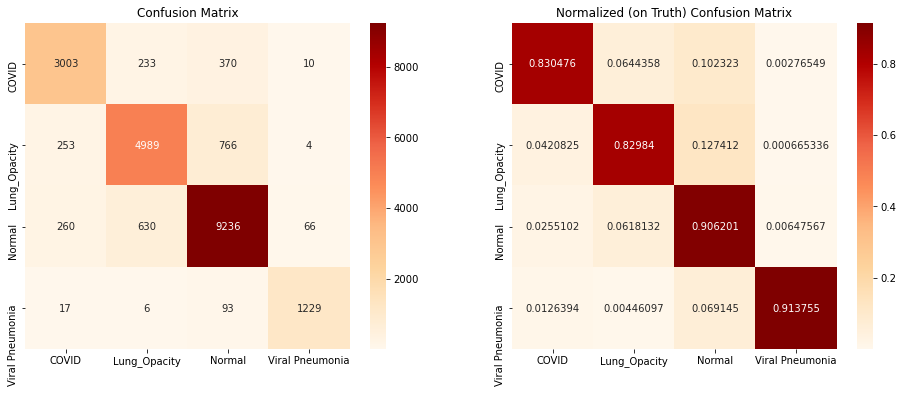

In [18]:
print(classification_report(cross_results[-4], cross_results[-3], target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(cross_results[-4], cross_results[-3]), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(cross_results[-4], cross_results[-3], normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

According to the 5-Fold cross validation results, **DenseNet 121** achieve the **macro f1 score** of `0.88` on four classes and overall **accuracy** of `0.87`. DenseNet-121 performs the **best in classifying viral pneumonia**, which the model achieves a **precision of 0.94**. The model performs **relatively worse** on classifying the **COVID and Lung opacity** with precisions of **0.85**.

Notice that there are **~10%** of COVID patients, **~13%** of lung opacity patients, and **~7%** of the Viral pneumonia patients being misclassified as normal patients. The macro recall on all four classes is **0.87**.

---

### 29. ROC Curve for the Classification of each Class.
The cell below will print the ROC curves for the classification of each class and a macro ROC curve.

The codes in the cell below come from the **scikit-learn's** tutorial for plotting ROC curves for multiclass classification problems. [https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem)

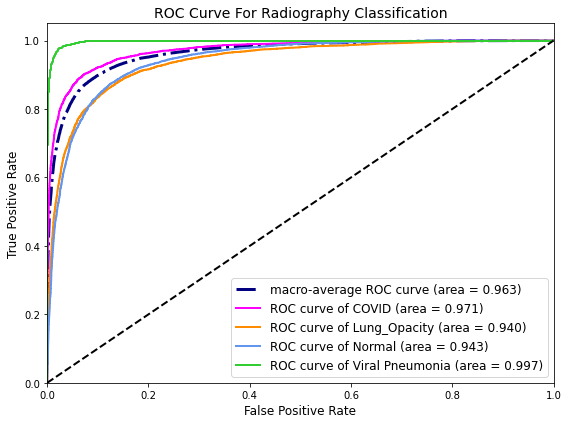

In [23]:
lw = 2

y_test = np.array(cross_results[-4]).reshape(-1, 1)

ohe_encoder = OneHotEncoder()
y_test = ohe_encoder.fit_transform(y_test).toarray()
n_classes = y_test.shape[1]

y_score = np.array(cross_results[-1])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle='-.', linewidth=3)

colors = ['magenta', 'darkorange', 'cornflowerblue', 'limegreen']
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle='-',
             label='ROC curve of {0:s} (area = {1:0.3f})'
             ''.format(data_xrays.classes[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve For Radiography Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

Notice that we achieve a **macro (unweighted) AUC of 0.963**. As suggested by the AUC, we have the best performance on classifying the **Viral pneumonia infection** with an AUC of **0.997**.

---

## Discussion of the Results

### 30. How do these Results do when Compared to the Human Experts?

According to Islam et al.[1], clinicians have an **accuracy of 80.6%** when diagnosing COVID-19 using patients' Chest X-ray Images. **DenseNet** achieves **higher accuracy of 83%** ($= \frac{3003}{3616} \times 100\%$). Clinicians also incorrectly conclude COVID-19 infection in **28.5%** of normal patients [1]. There are only **260 (2.5% of)** normal patients being classified as COVID by DenseNet-121. A smaller portion of patients is misclassified by CNN as COVID-19 infected.

However, we are more interested in the **false-negative rate** when assessing the diagnosis accuracy of fatal diseases, such as COVID-19. According to Cellina et al. [2], human experts' diagnosis of COVID-19 using Chest X-rays has a **sensitivity of 69%**. The sensitivity/recall of DenseNet's classification on COVID-19 is **0.83 (83%)**, which is much higher than the human experts.

The benefits of using Chest X-rays in diagnosing the COVID-19 infections include **giving timely test results** (laboratory tests usually need more than 24 hours) and **high accuracy of diagnosis**. 


References:  
[1] Islam, N., et al., "How accurate is chest imaging for diagnosing COVID-19?", [https://www.cochrane.org/CD013639/INFECTN_how-accurate-chest-imaging-diagnosing-covid-19](https://www.cochrane.org/CD013639/INFECTN_how-accurate-chest-imaging-diagnosing-covid-19)  
[2] Cellina, M., et al., "False negative chest X-Rays in patients affected by COVID-19 pneumonia and corresponding chest CT findings",[https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7211752/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7211752/)

### 31. Grouping All Diseased Patients into the Diseased Class: Overall FNR in Diagnosing
We will group patients with COVID, Lung Opacity, and Viral Pneumonia into a single label of diseased. This will allow us to see how many diseased patients will being **misclassified as healthy** (who would not get treatments or further investigations).

              precision    recall  f1-score   support

      Normal       0.88      0.91      0.89     10192
    Diseased       0.91      0.89      0.90     10973

    accuracy                           0.90     21165
   macro avg       0.90      0.90      0.90     21165
weighted avg       0.90      0.90      0.90     21165



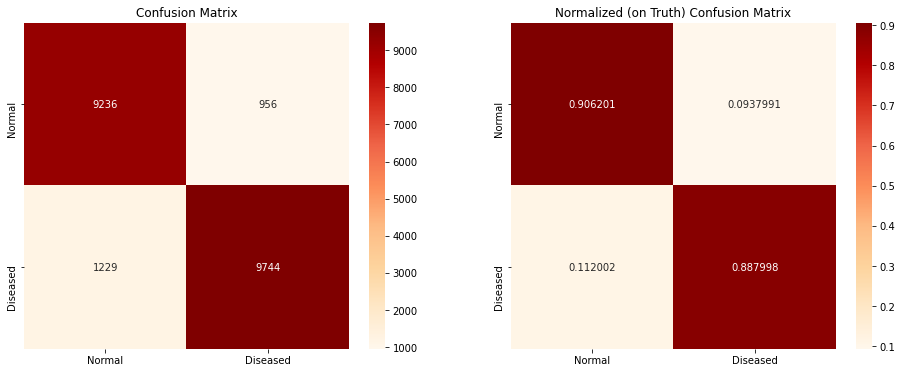

In [26]:
disease_truth = [0 if truth == data_xrays.class_to_idx["Normal"] else 1 for truth in cross_results[-4]]
disease_pred = [0 if pred == data_xrays.class_to_idx["Normal"] else 1 for pred in cross_results[-3]]

diseased_target_names = ["Normal", "Diseased"]

print(classification_report(disease_truth, disease_pred, target_names=diseased_target_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(disease_truth, disease_pred), 
                       columns=diseased_target_names, 
                       index=diseased_target_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(disease_truth, disease_pred, normalize="true"), 
                            columns=diseased_target_names, 
                            index=diseased_target_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

About **11.1%** of the diseased patients will be misclassified as healthy by the DenseNet-121. This FNR is generally better than that of the human clinicians when using Chest X-ray images. 

Nonetheless, the FNR of **11.1%** still exposes a problem of using the trained DenseNet-121 alone in diagnosing COVID infection. The results from the deep learning models should be **used as an aid/a reference** for clinicians, but they should **not replace** the clinician's assessments.

---

## Conclusions

In this project, we carefully investigate the **21165 Chest X-rays (CXR) images** using standard statistical measurements (mean, median, std, etc.), dimensionality reduction techniques (PCA), and relevant analytical tools for imagery data (e.g. spatial filtering). 

Our CNN architecture, **DenseNet-121**, produces classification results with better accuracy than that of the human experts. On the 5-fold cross-validation, DenseNet achieves an **overall accuracy of 0.87** on the 21165 Chest X-ray images. Even though the dataset is highly imbalanced (COVID : Lung Opacity : Normal : Viral Pneumonia = 17.1% : 28.4% : 48.2% : 6.3%), DenseNet still achieves a **macro f1 score of 0.88**. The **area under the curve (AUC)** for the classification of **COVID-19** is `0.97`, **Lung Opacity** is `0.94`, **Normal** is `0.94`, and **Viral Pneumonia** is `1.00`. 

This project serves as a good introduction to using CNN in classifying pneumonia infection using CXR. Additionally, it is also the first Ipython Notebook that provides a comprehensive review of the COVID-19 Radiography dataset and achieves state-of-the-art results on the Radiography classification problem.

The existing notebooks on the Kaggle either work on a subset of the dataset [1][2] or lack results and explanation to their methodology [3].

References:  
[1] Devireddy, N., "SMAI Project Kaggle dataset", [https://www.kaggle.com/naren10/smai-project-kaggle-dataset](https://www.kaggle.com/naren10/smai-project-kaggle-dataset)  
[2] Antoni, J., et al., "Assessment-Lungs X-ray Class COVID-Pneumonia", [https://www.kaggle.com/jcastanonv/lungs-x-ray-class-covid-pneumonia/](https://www.kaggle.com/jcastanonv/lungs-x-ray-class-covid-pneumonia/)  
[3] Maniyar, S., "Classification of COVID-19 using CNN" [https://www.kaggle.com/sejalanishmaniyar/classification-of-covid-19-using-cnn](https://www.kaggle.com/sejalanishmaniyar/classification-of-covid-19-using-cnn)